# W207 Final Project
## Bike Sharing Demand Kaggle Competition
Team Members: Zach Ingbretsen, Nicholas Chen, Keri Wheatley, and Rob Mulla

Kaggle Website Link: https://www.kaggle.com/c/bike-sharing-demand

## Business Understanding

A public bicycle-sharing system is a service in which bicycles are made available for a shared use to individuals on a very short-term basis. A bike-sharing system is comprised of a network of kiosks throughout a city which allows a participant to check-out a bike at one location and return it to a different location. Participants of a bike-sharing system can rent bikes on an as-needed basis and are charged for the duration of rental. Most programs require participants to register as users prior to usage. As of December 2016, roughly 1000 cities worldwide have bike-sharing systems.

Bike-sharing kiosks act as sensor networks for recording customer demand and usage patterns. For each bike rental, data is recorded for departure location, arrival location, duration of travel, and time elapsed. This data has valuable potential to researchers for studying mobility within a city. For this project, we explore customer mobility in relationship to these factors:
1.     Time of day
2.     Day type (workday, weekend, holiday, etc.)
3.     Season (Spring, Summer, Fall, Winter)
4.     Weather (clear, cloudy, rain, fog, snowfall, etc.)
5.     Temperature (actual, “feels like”)
6.     Humidity
7.     Windspeed

This project explores changes in demand given changes in weather and day. Our project delivers an exploratory data analysis as well as a machine-learning model to forecast bike rental demand. Bike rental demand is measured by total rental count which is further broken down into two rental types: rentals by registered users and rentals by non-registered users.

## Data Understanding

The data sources for this project are provided by Kaggle. Datasets include train data, test data without results, and an example solution submission.

### Data Features

| Feature    | Description                                                                                                                                                                                                                                                                    |
|------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| datetime   | hourly date + timestamp                                                                                                                                                                                                                                                         |
| season     | **1** = spring, **2** = summer, **3** = fall, **4** = winter                                                                                                                                                                                                                                   |
| holiday    | whether the day is considered a holiday                                                                                                                                                                                                                                        |
| workingday | whether the day is neither a weekend nor holiday                                                                                                                                                                                                                               |
| weather    | **1:** Clear, Few clouds, Partly cloudy, Partly cloudy **2:** Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  **3:** Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  **4:** A Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| temp       | temperature in Celsius                                                                                                                                                                                                                                                         |
| atemp      | "feels like" temperature in Celsius                                                                                                                                                                                                                                            |
| humidity   | relative humidity                                                                                                                                                                                                                                                              |
| windspeed  | wind speed                                                                                                                                                                                                                                                                     |
| casual     | number of non-registered user rentals initiated                                                                                                                                                                                                                                |
| registered | number of registered user rentals initiated                                                                                                                                                                                                                                    |
| count      | number of total rentals                    

## Exploratory Data Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import make_scorer

# Custom classes for this assignment
from code import feature_engineering as fe
from code import bikeshare as bs
reload(bs)
reload(fe)

<module 'code.feature_engineering' from 'code/feature_engineering.pyc'>

/Users/zingbretsen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [23]:
# Import our datasets
train_df = pd.read_csv('data/train.csv', index_col=0, infer_datetime_format=True)
train_df.index.name=None # Remove index name to remove confusing datetime column
train_df.index = pd.to_datetime(train_df.index) # Convert index to datetime
test_df = pd.read_csv('data/test.csv', index_col=0, infer_datetime_format=True)
test_df.index.name=None # Remove index name to remove confusing datetime column
test_df.index = pd.to_datetime(test_df.index) # Convert index to datetime

train_df['windspeed'] = train_df['windspeed'].where(train_df['windspeed'] > 1, np.nan)
train_df['humidity'] = train_df['humidity'].where(train_df['humidity'] > 1, np.nan)
train_df['windspeed'] = train_df['windspeed'].ffill().bfill()
train_df['humidity'] = train_df['humidity'].ffill().bfill()

test_df['windspeed'] = test_df['windspeed'].where(test_df['windspeed'] > 1, np.nan)
test_df['humidity'] = test_df['humidity'].where(test_df['humidity'] > 1, np.nan)
test_df['windspeed'] = test_df['windspeed'].ffill().bfill()
test_df['humidity'] = test_df['humidity'].ffill().bfill()

In [24]:
# Describe the numeric features
numeric_features = ['temp','atemp','humidity','windspeed','casual','registered','count']
train_df[numeric_features].describe()

              temp         atemp      humidity     windspeed        casual  \
count  10886.00000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      20.23086     23.655084     62.074407     13.802767     36.021955   
std        7.79159      8.474601     19.093238      7.045744     49.960477   
min        0.82000      0.760000      8.000000      6.003200      0.000000   
25%       13.94000     16.665000     47.000000      7.001500      4.000000   
50%       20.50000     24.240000     62.000000     12.998000     17.000000   
75%       26.24000     31.060000     78.000000     16.997900     49.000000   
max       41.00000     45.455000    100.000000     56.996900    367.000000   

         registered         count  
count  10886.000000  10886.000000  
mean     155.552177    191.574132  
std      151.039033    181.144454  
min        0.000000      1.000000  
25%       36.000000     42.000000  
50%      118.000000    145.000000  
75%      222.000000    284.000000  
max      

The table above shows the characteristics of numeric variables.

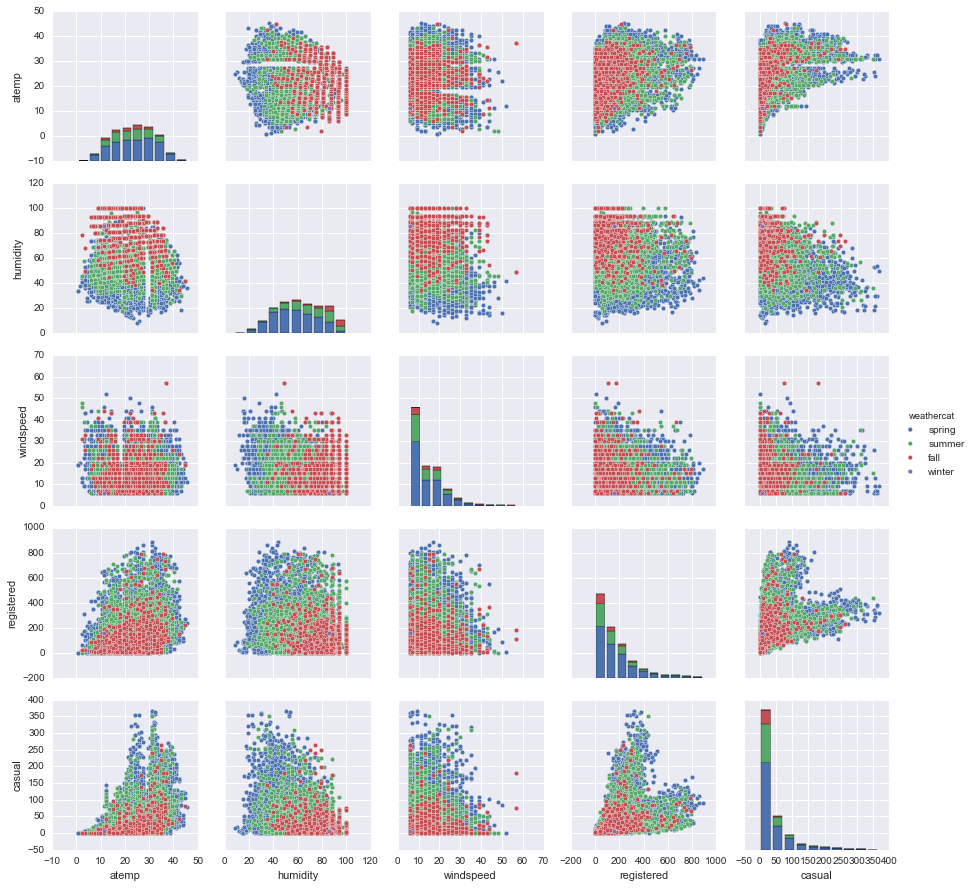

In [4]:
#create a copy of train_df for EDA transformations
train_df_mod = train_df.copy()

# Create a categorical weather column
train_df_mod['weathercat'] = train_df_mod['weather'].astype('category').\
    cat.rename_categories(['spring','summer','fall','winter'])
    
# Scatterplot all variables
scatplot_train = train_df_mod[['atemp','humidity','windspeed','registered','casual','weathercat']]
sns.pairplot(scatplot_train, hue="weathercat");
del train_df_mod['weathercat']

The correlation matrix above shows the relationships between the relationships between features and resulting counts. 

1. It appears that atemp affects registered rides linearly while atemp has a more exponential relationship with casual rides.

2. It appears that higher humidities (with humidities greater than 50% being more uncomfortable) affects casual rides more than registered rides.

3. There are many instances of 0 value for wind speed and humidity. Does this point to a data quality issue? 

4. Casual ride data has more variability than registered ride data.

In [5]:
# Do we need this?
# Temp vs Riders Color of rider type
# TODO: MAKE INTO GRID AND ADD ADDITIONAL FEATURES
#fig, axs = plt.subplots(ncols=3)
# sns.jointplot(x="atemp", y="count", color="g", data=train_df, size=3);
# sns.jointplot(x="tempsq", y="count", color="m", data=train_df, size=3);
# sns.jointplot(x="windspeed", y="count", color='b', data=train_df, size=3);

# Do we need this?
# sns.distplot(train_df.atemp, bins=20, kde=False, rug=True);
# sns.lmplot(x='temp', y='count', data=train_df, aspect=1.5, scatter_kws={'alpha':0.2})

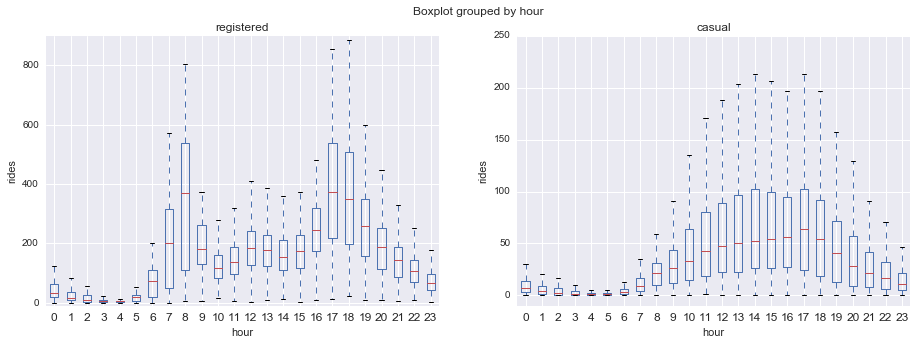

In [6]:
# Create boxplots for registered/casual rides by hour
train_df_mod = bs.eda_transform(train_df_mod)
test = bs.boxplot_by_hour(train_df_mod)

From the boxplots above, it is apparent that there are different distributions throughout the day for registered and casual rides. For registered rides, we see two usage spikes throughout the day; the first spike occurs between 7-8AM and the second spike occurs between 5-6PM. The casual rides have a fairly normal distribution between 7AM and 11PM. The different distributions of registered and casual rides indicate that we should create two separate models and combine then combine these models to calculate the final ride count.

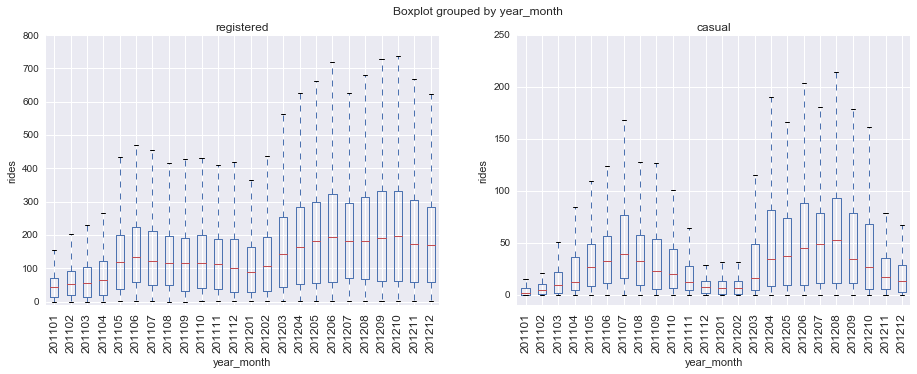

In [7]:
# Create boxplots for registered/casual rides throughout time
bs.boxplot_by_yearmonth(train_df_mod)

The boxplots above show some characteristics of registered and casual rides. Both casual and registered rides show seasonal variability, and the seasonal variability is more pronounced for casual rides than registered rides. After accounting for seasonality, it is apparent that the total number of rides is increasing over time as more people join the ride sharing program. This indicates that features for season/month and days from inception will be important features for the model. Seasonal variation appears less pronounced in the registered rides than for casual rides. For registered rides, variation from season to season seems to be strongest, whereas for casual rides, there is a significant variance in rides from month to month.

## Data Preparation

### Label

We will model the data based on log transformation of the registered and casual labels.

In [25]:
# Log transform registered and casual rides
train_df['log_casual'] = np.log(train_df['casual']+1)
train_df['log_registered'] = np.log(train_df['registered']+1)

### Features

We define a pipeline to preprocess the feature data using these steps:

1. Create features from the datetime feature: hour, weekday, week of the year, quarter, year, day of the month, weekend.

2. Create the squared of these features: temp, atemp, humidity


... I think there is more that this does...


In [26]:
# Define steps in pipeline


pipeline = bs.define_pipeline()
print(pipeline)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(steps=[('select_cat', SelectCols(cols=('season', 'holiday', 'workingday'), invert=False)), ('onehot', OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_val...          presort='auto', random_state=2, subsample=1.0, verbose=0,
             warm_start=False))])


### Split for Train and Development Data

W we will split the train data into a train and dev dataset. Since the Kaggle data is being tested on days 21-30, we will follow the same method and split train and dev by 1-16 day of month and 17-19 day of month.

In [27]:
# Split the data into train data and a dev data based on day of the month.
train_data = train_df[train_df.index.day <= 16]
dev_data = train_df[train_df.index.day > 16]

## Modeling

### Scoring

Before we begin modelling, we define a custom scorer. 

RSME is defined as ...

In [28]:
# Define RMSE scorer
RMSE_scorer = make_scorer(bs.get_RMSE, greater_is_better = False)

### Model

Based on testing outside of this final write-up, we decided to use GradientBoost as the basis for our model.

### Parameter Tuning

We will run parameter tuning on the data to find the best parameters. These are the relevant parameters for GradientBoost. The charts below show how RMSE is impacted by manipulating each of these parameters in isolation.

1. n_estimators
2. learning_rate
3. max_depth
4. min_samples_leaf

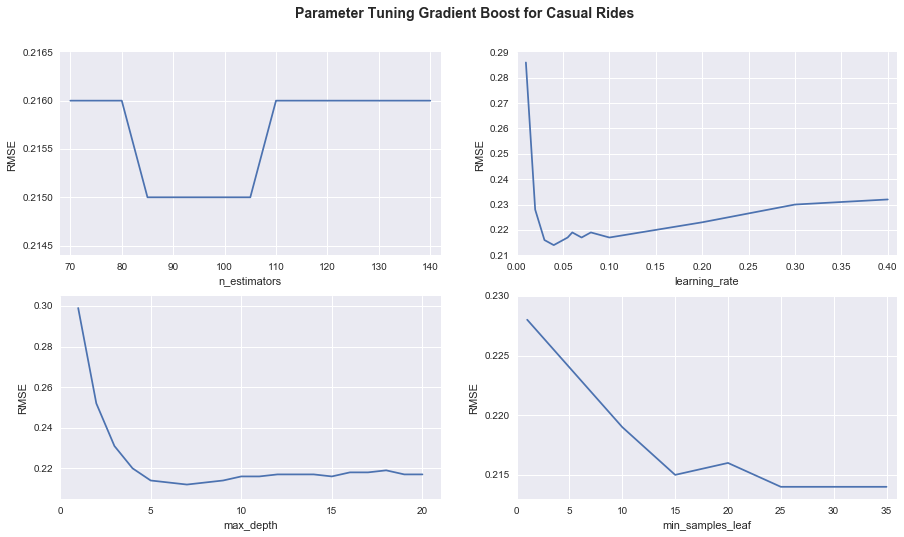

In [12]:
bs.param_tuning_graphs_abbrev_casual()

# [NC NOTE]  - Do we need the following two steps?  
We're not actually doing any real gridsearch here since we are just feeding set parameter values to the train dev model search function. I vote for removing this section and replacing with a write-up describing our gridsearch process. Perhaps the write-up can reference the train_dev_model_search function if we want to show our process.

### Parameter Tuning with GridSearch


In [43]:
from code import bikeshare_expt as bs
reload(bs)
reload(fe)
## Test for casual and registered separately
pipeline = bs.define_pipeline()
parameters = {
    'clf__n_estimators': (80,),
    'clf__learning_rate': (0.05,),
    'clf__max_depth': (10,),
    'clf__min_samples_leaf': (20,),
    'union__numerical__rollingweather__window': (3,),
    'union__numerical__forecast__use': (True,),
    # 'union__categorical__select_cat__cols': (['season', 'holiday', 'workingday'], ['season', 'workingday'], ['holiday', 'workingday'], ['season', 'holiday'], ['workingday']),
    # 'union__numerical__daily_max__cols': (['weather'],),
    # 'union__numerical__daily_mean__cols': (['weather', 'temp'],),
 }


print "Casual rides"
bs.train_dev_model_search(pipeline, train_data, dev_data, 'log_casual', parameters, RMSE_scorer)


GridSearch RMSE -0.237395226602
RMSE:  0.212621187668
Done in 19.259s

Best parameters set:
	clf__learning_rate: 0.05
	clf__max_depth: 10
	clf__min_samples_leaf: 20
	clf__n_estimators: 80
	union__numerical__forecast__use: True
	union__numerical__rollingweather__window: 3


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s finished


Casual rides
Performing grid search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [44]:
## Test for casual and registered separately
parameters = {
    'clf__n_estimators': (115,),
    'clf__learning_rate': (0.05,),
    'clf__max_depth': (10,),
    'clf__min_samples_leaf': (20,),
    'union__numerical__rollingweather__window': (4,),
    'union__numerical__forecast__use': (True,),
    # 'union__categorical__select_cat__cols': (['season', 'holiday', 'workingday'], ['season', 'workingday'], ['holiday', 'workingday'], ['season', 'holiday'], ['workingday']),
    # 'union__numerical__daily_max__cols': (None, ),
    # 'union__numerical__daily_mean__cols': (['weather'],),
}

print "Registered rides"
bs.train_dev_model_search(pipeline, train_data, dev_data, 'log_registered', parameters, RMSE_scorer)

GridSearch RMSE -0.119795215665
RMSE:  0.0850422748125
Done in 24.001s

Best parameters set:
	clf__learning_rate: 0.05
	clf__max_depth: 10
	clf__min_samples_leaf: 20
	clf__n_estimators: 115
	union__numerical__forecast__use: True
	union__numerical__rollingweather__window: 4


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.5s finished


Registered rides
Performing grid search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


## Evaluation

In [0]:
reload(bs)
reload(fe)
features = [c for c in train_df.columns if c not in ['count', 'casual', 'registered', 'log_casual', 'log_registered', 'log_count']]
# Create full model using all train data
full_casual_gs = pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 3,
        # union__numerical__daily_max__cols = ['weather'],
        # union__numerical__daily_mean__cols = ['weather','temp'],
    )
full_casual_gs.fit(train_df[features], train_df['log_casual'])
full_casual_predicted_y_log = full_casual_gs.predict(test_df[features])
# np.exp converts back from log
full_casual_predicted_y = np.exp(full_casual_predicted_y_log)-1
full_registered_gs = pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 4,
        # union__numerical__daily_max__cols = None,
        # union__numerical__daily_mean__cols = ['weather'],
)
full_registered_gs.fit(train_df[features], train_df['log_registered'])
full_registered_predicted_y_log = full_registered_gs.predict(test_df[features])
# np.exp converts back from log
full_registered_predicted_y = np.exp(full_registered_predicted_y_log)-1


Predict casual and registered for training

In [57]:
full_casual_gs = pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 3,
        # union__numerical__daily_max__cols = ['weather'],
        # union__numerical__daily_mean__cols = ['weather','temp'],
    )
full_casual_gs.fit(train_df[features], train_df['log_casual'])
print(len(train_df))
full_casual_predicted_train_y_log = full_casual_gs.predict(train_df[features])
print(len(full_casual_predicted_train_y_log ))
# np.exp converts back from log
full_casual_predicted_train_y = np.exp(full_casual_predicted_train_y_log)-1
full_registered_gs = pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 4,
        # union__numerical__daily_max__cols = None,
        # union__numerical__daily_mean__cols = ['weather'],
)
full_registered_gs.fit(train_df[features], train_df['log_registered'])
full_registered_predicted_train_y_log = full_registered_gs.predict(train_df[features])
# np.exp converts back from log
full_registered_predicted_train_y = np.exp(full_registered_predicted_train_y_log)-1


10886
10886


Predict casual and registered for test

In [58]:
full_casual_gs = pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 3,
        # union__numerical__daily_max__cols = ['weather'],
        # union__numerical__daily_mean__cols = ['weather','temp'],
    )
full_casual_gs.fit(train_df[features], train_df['log_casual'])
full_casual_predicted_y_log = full_casual_gs.predict(test_df[features])
# np.exp converts back from log
full_casual_predicted_y = np.exp(full_casual_predicted_y_log)-1
full_registered_gs = pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 4,
        # union__numerical__daily_max__cols = None,
        # union__numerical__daily_mean__cols = ['weather'],
)
full_registered_gs.fit(train_df[features], train_df['log_registered'])
full_registered_predicted_y_log = full_registered_gs.predict(test_df[features])
# np.exp converts back from log
full_registered_predicted_y = np.exp(full_registered_predicted_y_log)-1

Merge predictions in

In [66]:
train_big_df = train_df.copy()
test_big_df = test_df.copy()
print(len(train_big_df))
print(len(full_casual_predicted_train_y_log ))
train_big_df['log_casual'] = full_casual_predicted_train_y_log
train_big_df['log_registered'] = full_registered_predicted_train_y_log
test_big_df['log_casual'] = full_casual_predicted_y_log
test_big_df['log_registered'] = full_registered_predicted_y_log


10886
10886


Grid search log count for training with casual and registered

In [74]:
reload(bs)
pipeline = bs.define_massive_pipeline()
# pipeline.set_params(
#         clf__n_estimators = 115, 
#         clf__learning_rate = 0.05, 
#         clf__max_depth = 10, 
#         clf__min_samples_leaf = 20,
#         union__numerical__forecast__use = True,
# 	union__numerical__rollingweather__window = 3,
#         # union__numerical__daily_max__cols = ['weather'],
#         # union__numerical__daily_mean__cols = ['weather','temp'],
#     )

parameters = {
    'clf__n_estimators': (80, 100, 115,),
    'clf__learning_rate': (0.05,),
    'clf__max_depth': (10,),
    'clf__min_samples_leaf': (20,),
    'union__numerical__rollingweather__window': (4,),
    'union__numerical__forecast__use': (True,),
    # 'union__categorical__select_cat__cols': (['season', 'holiday', 'workingday'], ['season', 'workingday'], ['holiday', 'workingday'], ['season', 'holiday'], ['workingday']),
    # 'union__numerical__daily_max__cols': (None, ),
    # 'union__numerical__daily_mean__cols': (['weather'],),
}
train_big_data = train_big_df[train_df.index.day <= 16]
dev_big_data = train_big_df[train_df.index.day > 16]

features = [c for c in train_df.columns if c not in ['count', 'casual', 'registered', 'log_count']]

bs.train_dev_big_model_search(pipeline, train_big_data, dev_big_data, 'log_count', parameters, RMSE_scorer)
# gs = bs.GridSearchCV(pipeline, parameters, n_jobs=1, verbose=1, scoring=RMSE_scorer)
# gs.fit(train_big_data[features], train_big_data['log_count'])
# gs.predict(dev_big_data[features])

GridSearch RMSE -0.112712323198
RMSE:  0.0795684262658
Done in 53.567s

Best parameters set:
	clf__learning_rate: 0.05
	clf__max_depth: 10
	clf__min_samples_leaf: 20
	clf__n_estimators: 115
	union__numerical__forecast__use: True
	union__numerical__rollingweather__window: 4


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   44.8s finished
code/feature_engineering.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['quarter'] = X.index.quarter


Performing grid search...
{'clf__n_estimators': (80, 100, 115), 'clf__max_depth': (10,), 'clf__learning_rate': (0.05,), 'clf__min_samples_leaf': (20,), 'union__numerical__rollingweather__window': (4,), 'union__numerical__forecast__use': (True,)}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


Predict count for test with casual and registered

In [96]:
reload(bs)
pipeline = bs.define_massive_pipeline()
pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 3,
        # union__numerical__daily_max__cols = ['weather'],
        # union__numerical__daily_mean__cols = ['weather','temp'],
    )
print(len(train_big_df[features]))
print(len(train_big_df['log_count']))
pipeline.fit(train_big_df[features], train_big_df['log_count'])


Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(steps=[('select_cat', SelectCols(cols=('season', 'holiday', 'workingday'), invert=False)), ('onehot', OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_val...tors=115, presort='auto', random_state=2,
             subsample=1.0, verbose=0, warm_start=False))])

10886
10886


In [97]:
preds = pipeline.predict(test_big_df[features])
test_big_df['count'] = np.exp(preds) - 1

test_big_df['count'] = (np.array([full_casual_predicted_y>0]*full_casual_predicted_y)).T+\
    (np.array([full_registered_predicted_y>0]*full_registered_predicted_y)).T
test_big_df.index.names = ['datetime']
test_big_df[['count']].to_csv('data/massive_combined_preds.csv')

In [47]:
big_train = train_df.copy()
big_train['casual'] = full_casual_predicted_y_log 
big_train['registered'] = full_registered_predicted_y_log 

ValueError: Length of values does not match length of index

## Deployment

In [119]:
test_df['count'] = (np.array([full_casual_predicted_y>0]*full_casual_predicted_y)).T+\
    (np.array([full_registered_predicted_y>0]*full_registered_predicted_y)).T
test_df.index.names = ['datetime']
test_df[['count']].to_csv('data/combined_preds.csv')

In [32]:
no_wind = train_df[test_df['windspeed'] < 1]
print(len(no_wind))
no_wind

IndexingError: Unalignable boolean Series key provided

/Users/zingbretsen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


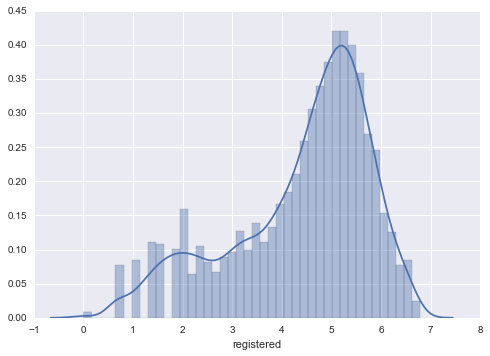

In [24]:
sns.distplot(np.log(1 + train_df['registered']))

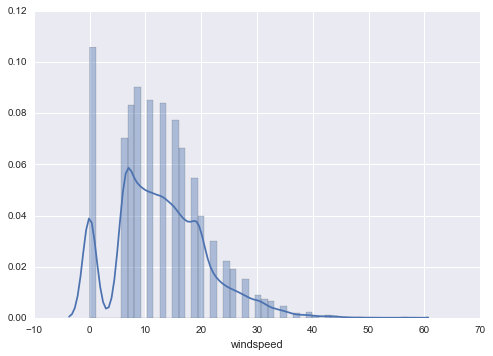

In [30]:
sns.distplot(train_df['windspeed'])

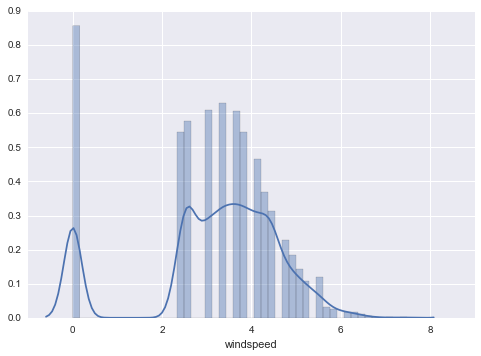

In [37]:
sns.distplot(np.sqrt(test_df['windspeed']))

In [132]:
reload(fe)
reload(bs)
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
regist_wrapped = fe.RegWrapper(GradientBoostingRegressor(
            n_estimators=115,
            random_state=2,
            learning_rate = 0.05,
            max_depth = 10,
            min_samples_leaf = 20,
        ), y =train_df['log_registered'] )
       
count = regist_wrapped.fit(train_df[features])

In [0]:
reload(bs)
bs.define_pipeline.fit(train_df.copy()

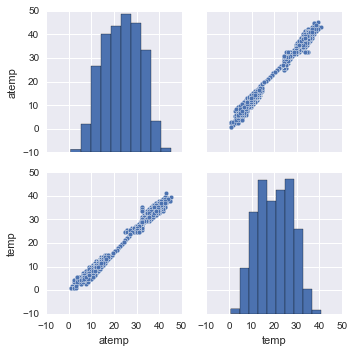

                     season  holiday  workingday  weather  temp   atemp  \
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  count  \
2011-01-01 00:00:00      81.0     6.0032       3          13     16   
2011-01-01 01:00:00      80.0     6.0032       8          32     40   
2011-01-01 02:00:00      80.0     6.0032       5          27     32   
2011-01-01 03:00:00      75.0     6.0032       3          10     13   
2011-01-01 04:00:00      75.0     6.0032       0           1      1   

                     log_casual  log_registered  
2011-01-01 00:00:00    1.386294        2.639057  
2011-01-01 01:00:00   

In [195]:
#train_df[
# train_df.iloc[np.where(train_df['atemp'] - 11 < 0.5)]
